In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
from gpflow.utilities import print_summary

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [3]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [366]:
x_subsample = x.final.b_nn_corrected[::30][500:]
time_subsample = x.base_signals.t_b_nn[::30][500:]
mean = np.mean(x_subsample)
X, Y = time_subsample, x_subsample - mean
X, Y = X[np.greater_equal(Y, -2)],  Y[np.greater_equal(Y, -2)]
X, Y = X[np.less_equal(Y, 3)],  Y[np.less_equal(Y, 3)]
X, Y = X.reshape(-1,1), Y.reshape(-1,1)

N = np.size(X)

In [367]:
X.shape

(801, 1)

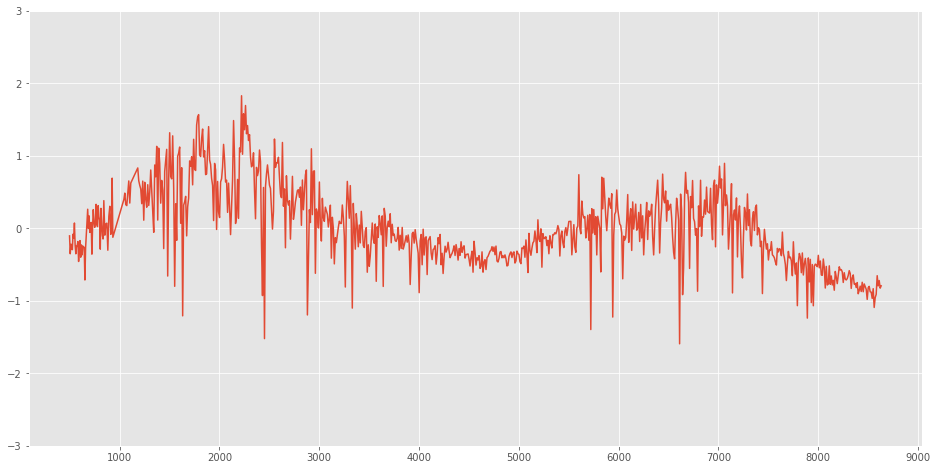

In [368]:
plt.figure(5, figsize=(16, 8))
plt.ylim(-3, 3)
plt.plot(X, Y)

In [369]:
N=150
interval = (np.min(time_subsample), np.max(time_subsample))
time_indicies=np.linspace(interval[0], interval[1], N)

In [370]:
def find_nearest(array, values):
    indices = np.zeros(values.shape)
    for index, value in enumerate(values):
        indices[index] = np.abs(array - value).argmin()
    return indices

In [371]:
np.size(find_nearest(X, time_indicies).astype(int))

150

In [372]:
indices = find_nearest(X, time_indicies).astype(int)

kernel = gpflow.kernels.Sum([gpflow.kernels.Matern32(),gpflow.kernels.White()])
Z = X[indices].copy()  # Initialise inducing locations
M = np.size(Z)
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
m.kernel.kernels[0].lengthscale.assign(427)
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  427.0
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z            Parameter                  True         (150, 1)       float64  [[498.119...
SVGP.q_mu                           Parameter                  True         (150, 1)       float64  [[0....
SVGP.q_sqrt                         Parameter  FillTriangular  True         (1, 150, 150)  float64  [[[1., 0., 0....


In [373]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [374]:
%%timeit
log_likelihood(X, Y)

5.35 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [375]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [376]:
%%timeit
log_likelihood(*next(train_it))

2.26 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [377]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: 0.13475713320235627


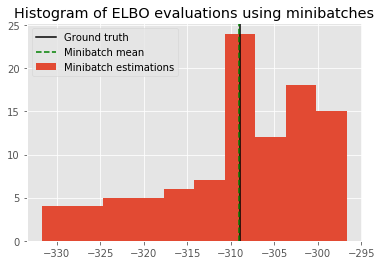

In [378]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [379]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

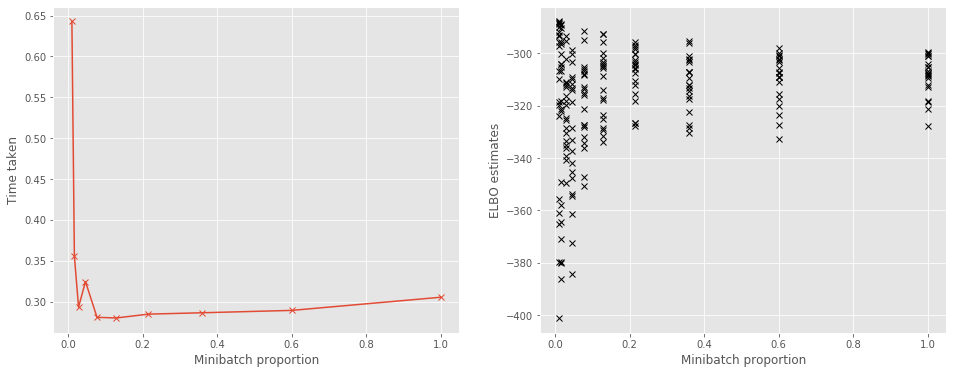

In [380]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(150, 1)


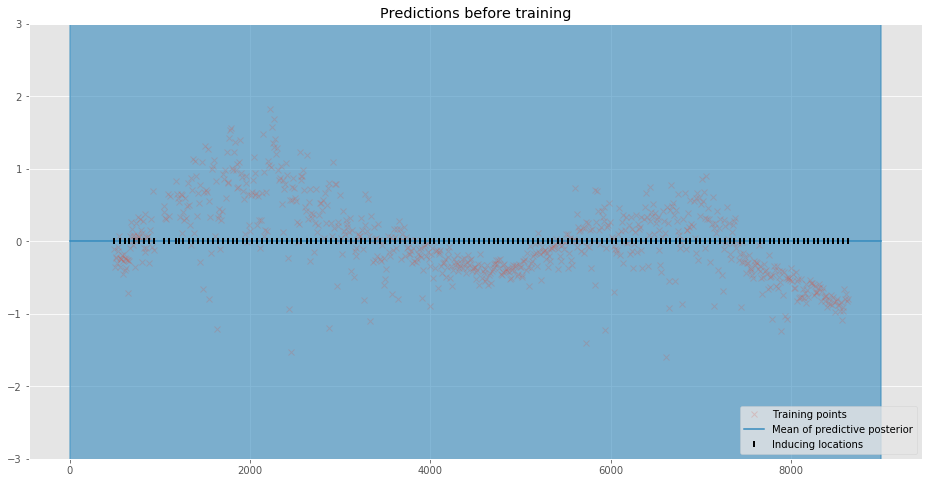

In [381]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(0, 9000, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    plt.ylim(-3, 3)

plot(title="Predictions before training")

In [382]:
minibatch_size = 100

# We turn of training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
We are on the step 1000
We are on the step 2000
We are on the step 3000
We are on the step 4000
We are on the step 5000
We are on the step 6000
We are on the step 7000
55.74923610687256


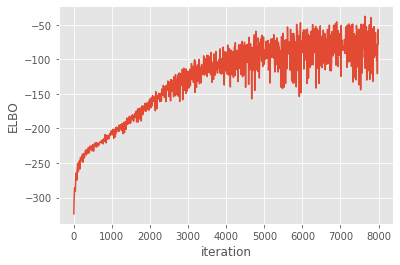

In [383]:
start = time.time()

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

(150, 1)


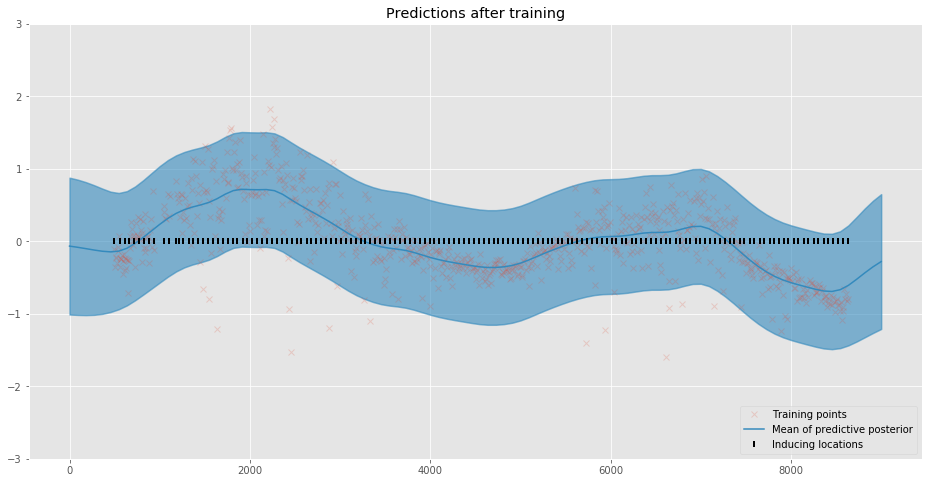

In [386]:
plot("Predictions after training")

# Kernel Design

In [446]:
from gpflow.utilities import print_summary, positive
from gpflow.utilities.ops import square_distance

In [447]:
class VirgoWhiteKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.variance_a = gpflow.Parameter(1.0, transform=positive())
        self.variance_b = gpflow.Parameter(1.0, transform=positive())
        
    def K(self, X, X2=None, presliced=None):
        if X2 is None:
            d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
            d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
            indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
            indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
            return tf.multiply(tf.linalg.diag(d_a), tf.linalg.diag(indices_a)) + tf.multiply(tf.linalg.diag(d_b), tf.linalg.diag(indices_b))
        else:
            shape = [X.shape[0], X2.shape[0]]
            return tf.zeros(shape, dtype=X.dtype)

    def K_diag(self, X, presliced=None):
        d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
        d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
        indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
        indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
        return tf.multiply(d_a, indices_a) + tf.multiply(d_b, indices_b)  

In [562]:
class VirgoMatern32Kernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0,1])
        self.variance = gpflow.Parameter(1.0, transform=positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
        
    def scaled_squared_euclid_dist(self, X, X2=None):
        """
        Returns ||(X - X2ᵀ) / ℓ||² i.e. squared L2-norm.
        """
        X_scaled = X / self.lengthscale
        X2_scaled = X2 / self.lengthscale if X2 is not None else X2
        return square_distance(X_scaled, X2_scaled)

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self.slice(X, X2)
        r2 = self.scaled_squared_euclid_dist(X[:, 0], X2[:, 0])
        return self.K_r2(r2)

    def K_diag(self, X, presliced=False):
        return tf.fill((X[:,0].shape[:-1]), tf.squeeze(self.variance))
        
    def K_r2(self, r):
        sqrt3 = np.sqrt(3.)
        return self.variance * (1. + sqrt3 * r) * tf.exp(-sqrt3 * r)

In [563]:
x_subsample_a = x.final.a_nn_corrected[::10000]
time_subsample_a = x.base_signals.t_a_nn[::10000]

x_subsample_b = x.final.b_nn_corrected[::30][500:]
time_subsample_b = x.base_signals.t_b_nn[::30][500:]

mean = np.mean(np.concatenate((x_subsample_a, x_subsample_b)))

X_a, Y_a = time_subsample_a, x_subsample_a - mean
X_a, Y_a = X_a[np.greater_equal(Y_a, -2)],  Y_a[np.greater_equal(Y_a, -2)]
X_a, Y_a = X_a[np.less_equal(Y_a, 3)],  Y_a[np.less_equal(Y_a, 3)]
#X_a, Y_a = X_a.reshape(-1,1), Y_a.reshape(-1,1)
X_a = np.stack((X_a, np.zeros(X_a.shape)))

X_b, Y_b = time_subsample_b, x_subsample_b - mean
X_b, Y_b = X_b[np.greater_equal(Y_b, -2)],  Y_b[np.greater_equal(Y_b, -2)]
X_b, Y_b = X_b[np.less_equal(Y_b, 3)],  Y_b[np.less_equal(Y_b, 3)]
#X_b, Y_b = X_b.reshape(-1,1), Y_b.reshape(-1,1)
X_b = np.stack((X_b, np.zeros(X_b.shape)))


In [564]:
X = np.transpose(np.concatenate((X_a, X_b), axis=1)).reshape(-1, 2)
Y = np.transpose(np.concatenate((Y_a, Y_b), axis=0)).reshape(-1, 1)
N=np.size(Y)

In [565]:
X.shape

(1963, 2)

In [566]:
kernel = gpflow.kernels.Sum([VirgoMatern32Kernel(),VirgoWhiteKernel()])
kernel = VirgoMatern32Kernel()
#kernel = gpflow.kernels.Matern32()

In [567]:
Z = X[::30,:].copy()  # Initialise inducing locations
M = np.size(Z)

In [568]:
Z.shape

(66, 2)

In [569]:
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
#m.kernel.kernels[0].lengthscale.assign(427)

In [570]:
print_summary(m)

name                      class      transform       trainable    shape        dtype    value
------------------------  ---------  --------------  -----------  -----------  -------  ----------------
SVGP.kernel.variance      Parameter  Softplus        True         ()           float64  1.0
SVGP.kernel.lengthscale   Parameter  Softplus        True         ()           float64  1.0
SVGP.likelihood.variance  Parameter  Softplus        True         ()           float64  1.0
SVGP.inducing_variable.Z  Parameter                  True         (66, 2)      float64  [[48.026, 0....
SVGP.q_mu                 Parameter                  True         (66, 1)      float64  [[0....
SVGP.q_sqrt               Parameter  FillTriangular  True         (1, 66, 66)  float64  [[[1., 0., 0....


In [571]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [572]:
log_likelihood(X, Y)

ValueError: Dimensions must be equal, but are 66 and 1963 for 'Tensordot_1/MatMul' (op: 'MatMul') with input shapes: [1,66], [1963,1].